In [28]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [29]:
import numpy as np
from collections import Counter

input_file_segments = '/content/drive/MyDrive/Project/ExtractedSegments_1s_set2.npy'
input_file_labels = '/content/drive/MyDrive/Project/ExtractedLabelas_1s_set2.npy'

loaded_segments = np.load(input_file_segments, allow_pickle=True)
loaded_labels = np.load(input_file_labels, allow_pickle=True)

print(f'Total segments loaded: {len(loaded_segments)}')
print(f'Total labels loaded: {len(loaded_labels)}')
print(f'Sample segment shape: {loaded_segments[0].shape}')
print(f'Sample label: {loaded_labels[0]}')

label_counts = Counter(loaded_labels)
print(f'Label counts: {label_counts}')

max_count = max(label_counts.values())

def add_gaussian_noise(data, mean=0, std_dev=0.05):
    noise = np.random.normal(mean, std_dev, data.shape)
    return data + noise

augmented_segments = []
augmented_labels = []

for segment, label in zip(loaded_segments, loaded_labels):
    if segment.shape == (125, 16):
        augmented_segments.append(segment)
        augmented_labels.append(label)
    else:
        print(f"Skipping segment with invalid shape: {segment.shape}")

for label, count in label_counts.items():
    if count < max_count:
        label_segments = [seg for seg, lbl in zip(loaded_segments, loaded_labels) if lbl == label]

        num_samples_needed = max_count - count

        for _ in range(num_samples_needed):
            segment = label_segments[np.random.randint(len(label_segments))]
            noisy_segment = add_gaussian_noise(segment)

            if noisy_segment.shape == (125, 16):
                augmented_segments.append(noisy_segment)
                augmented_labels.append(label)
            else:
                print(f"Generated segment with invalid shape: {noisy_segment.shape}")

augmented_segments = np.array(augmented_segments)
augmented_labels = np.array(augmented_labels)

print(f'Augmented data shape: {augmented_segments.shape}')
print(f'Augmented labels shape: {augmented_labels.shape}')
print(f'New label counts: {Counter(augmented_labels)}')

Total segments loaded: 935
Total labels loaded: 935
Sample segment shape: (125, 16)
Sample label: Walking
Label counts: Counter({'Walking': 290, 'Aha': 290, 'Doing Other Task': 289, 'Impasse': 41, 'Re-evaluation': 25})
Skipping segment with invalid shape: (146, 16)
Skipping segment with invalid shape: (183, 16)
Generated segment with invalid shape: (146, 16)
Generated segment with invalid shape: (146, 16)
Generated segment with invalid shape: (146, 16)
Generated segment with invalid shape: (146, 16)
Generated segment with invalid shape: (146, 16)
Generated segment with invalid shape: (146, 16)
Generated segment with invalid shape: (146, 16)
Generated segment with invalid shape: (146, 16)
Generated segment with invalid shape: (146, 16)
Augmented data shape: (1439, 125, 16)
Augmented labels shape: (1439,)
New label counts: Counter({'Walking': 290, 'Aha': 290, 'Re-evaluation': 290, 'Doing Other Task': 289, 'Impasse': 280})


In [30]:
data = augmented_segments
final_labels = augmented_labels

In [31]:
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, ReLU, MaxPooling2D
from tensorflow.keras.layers import Flatten, Dense, Dropout, Reshape, LSTM
from tensorflow.keras.layers import GlobalAveragePooling2D, concatenate
import tensorflow as tf
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, DepthwiseConv2D, BatchNormalization, Activation, Dropout, Flatten, Dense, MaxPooling2D
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
import pandas as pd


In [32]:
import numpy as np


target_labels = ['Aha', 'Doing Other Task']

final_labels = np.array(final_labels)

mask = np.isin(final_labels, target_labels)

filtered_data = data[mask]
filtered_labels = final_labels[mask]

print(f"Filtered Data Shape: {filtered_data.shape}")
print(f"Filtered Labels Shape: {filtered_labels.shape}")

Filtered Data Shape: (569, 125, 16)
Filtered Labels Shape: (569,)


In [33]:
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, ReLU, MaxPooling2D
from tensorflow.keras.layers import Flatten, Dense, Dropout, Reshape, LSTM
from tensorflow.keras.layers import GlobalAveragePooling2D, concatenate
import tensorflow as tf
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, DepthwiseConv2D, BatchNormalization, Activation, Dropout, Flatten, Dense, MaxPooling2D
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
import pandas as pd

label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(filtered_labels)


from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
for train_index, test_index in skf.split(filtered_data, encoded_labels):
    X_train, X_test = filtered_data[train_index], filtered_data[test_index]
    y_train, y_test = encoded_labels[train_index], encoded_labels[test_index]

X_train = np.array(X_train, dtype=np.float32)
X_test = np.array(X_test, dtype=np.float32)
y_train = np.array(y_train, dtype=np.int32)
y_test = np.array(y_test, dtype=np.int32)

def build_e2fnet(input_shape=(125, 16, 1), num_classes=2):
    inputs = Input(shape=input_shape)

    x = Conv2D(32, (3, 3), padding="same", strides=(1, 1))(inputs)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(64, (3, 3), padding="same", strides=(1, 1))(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(128, (3, 3), padding="same")(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = GlobalAveragePooling2D()(x)

    temporal_features = Reshape((125, -1))(inputs)
    temporal_features = LSTM(64, return_sequences=True)(temporal_features)
    temporal_features = LSTM(64)(temporal_features)

    fused = concatenate([x, temporal_features])
    fused = Dropout(0.5)(fused)

    output = Dense(num_classes, activation="sigmoid")(fused)

    model = Model(inputs=inputs, outputs=output)
    return model


main_model = build_e2fnet(input_shape=(125, 16, 1), num_classes=1)
main_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

main_model.summary()

history = main_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=25, batch_size=32)

test_loss, test_accuracy = main_model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_accuracy:.4f}')

test_loss_train, test_accuracy_train = main_model.evaluate(X_train, y_train)
print(f'Train Accuracy: {test_accuracy_train:.4f}')

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6             │ (None, 125, 16, 1)     │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_18 (Conv2D)        │ (None, 125, 16, 32)    │            320 │ input_layer_6[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_18    │ (None, 125, 16, 32)    │            128 │ conv2d_18[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_18 (ReLU)           │ (None, 125, 16, 32)    │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_12          │ (None, 62, 8, 32)      │              0 │ re_lu_18[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_19 (Conv2D)        │ (None, 62, 8, 64)      │         18,496 │ max_pooling2d_12[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_19    │ (None, 62, 8, 64)      │            256 │ conv2d_19[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_19 (ReLU)           │ (None, 62, 8, 64)      │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_13          │ (None, 31, 4, 64)      │              0 │ re_lu_19[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_20 (Conv2D)        │ (None, 31, 4, 128)     │         73,856 │ max_pooling2d_13[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_20    │ (None, 31, 4, 128)     │            512 │ conv2d_20[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_6 (Reshape)       │ (None, 125, 16)        │              0 │ input_layer_6[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_20 (ReLU)           │ (None, 31, 4, 128)     │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_12 (LSTM)            │ (None, 125, 64)        │         20,736 │ reshape_6[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d… │ (None, 128)            │              0 │ re_lu_20[0][0]         │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_13 (LSTM)            │ (None, 64)             │         33,024 │ lstm_12[0][0]          │
├──────────────────────

 Total params: 147,521 (576.25 KB)

 Trainable params: 147,073 (574.50 KB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 91ms/step - accuracy: 0.5284 - loss: 0.7699 - val_accuracy: 0.6991 - val_loss: 0.9333
Epoch 2/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.7820 - loss: 0.6101 - val_accuracy: 0.8053 - val_loss: 0.6880
Epoch 3/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.8586 - loss: 0.4799 - val_accuracy: 0.7788 - val_loss: 0.6557
Epoch 4/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9242 - loss: 0.2846 - val_accuracy: 0.8230 - val_loss: 0.4471
Epoch 5/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.9636 - loss: 0.1679 - val_accuracy: 0.8850 - val_loss: 0.2855
Epoch 6/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.9837 - loss: 0.1109 - val_accuracy: 0.8496 - val_loss: 0.4016
Epoch 7/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9755 - loss: 0.1063 - val_accuracy: 0.8584 - val_loss: 0.3715
Epoch 8/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9368 - loss: 0.2091 - val_accuracy: 0.8584 - v

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


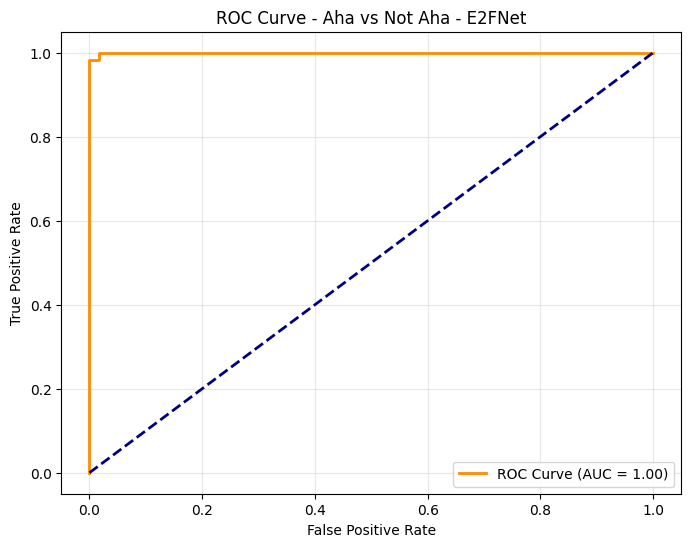

Precision: 0.8750
Recall: 1.0000
F1 Score: 0.9333

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.86      0.92        57
           1       0.88      1.00      0.93        56

    accuracy                           0.93       113
   macro avg       0.94      0.93      0.93       113
weighted avg       0.94      0.93      0.93       113



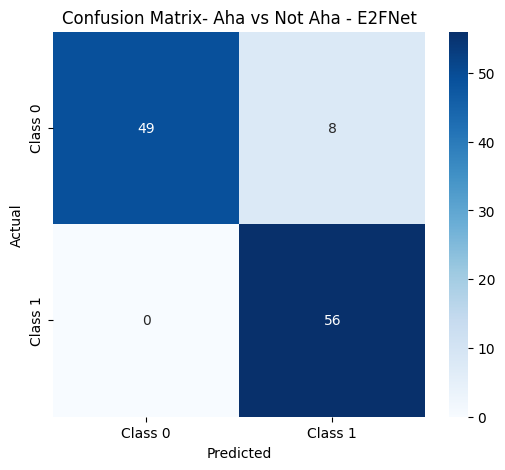

In [36]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, confusion_matrix
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, classification_report

y_pred_prob = main_model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Aha vs Not Aha - E2FNet')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

print("\nClassification Report:\n", classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix- Aha vs Not Aha - E2FNet')
plt.show()

In [35]:
spatial_model = Model(inputs=main_model.input, outputs=main_model.get_layer('global_average_pooling2d_1').output)
temporal_model = Model(inputs=main_model.input, outputs=main_model.get_layer('lstm_3').output)

X_train_spatial = spatial_model.predict(X_train)
X_train_temporal = temporal_model.predict(X_train)
X_test_spatial = spatial_model.predict(X_test)
X_test_temporal = temporal_model.predict(X_test)

X_train_features = np.concatenate([X_train_spatial, X_train_temporal], axis=1)
X_test_features = np.concatenate([X_test_spatial, X_test_temporal], axis=1)
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import pandas as pd
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

classifiers = {
    "SVM": SVC(),
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "XGBoost": XGBClassifier(),
    "K-Neighbors": KNeighborsClassifier(),
    "Logistic Regression": LogisticRegression()
}

results = {}

for clf_name, clf in classifiers.items():
    clf.fit(X_train_features, y_train)

    y_pred_train = clf.predict(X_train_features)
    y_pred_test = clf.predict(X_test_features)

    train_accuracy = accuracy_score(y_train, y_pred_train)
    train_precision = precision_score(y_train, y_pred_train, average='weighted')
    train_recall = recall_score(y_train, y_pred_train, average='weighted')
    train_f1 = f1_score(y_train, y_pred_train, average='weighted')

    test_accuracy = accuracy_score(y_test, y_pred_test)
    test_precision = precision_score(y_test, y_pred_test, average='weighted')
    test_recall = recall_score(y_test, y_pred_test, average='weighted')
    test_f1 = f1_score(y_test, y_pred_test, average='weighted')

    print(f"\nClassifier: {clf_name}")
    print(f"Train Accuracy: {train_accuracy:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print(f"Test Precision: {test_precision:.4f}")
    print(f"Test Recall: {test_recall:.4f}")
    print(f"Test F1 Score: {test_f1:.4f}")
    print("Classification Report (Test Data):")
    print(classification_report(y_test, y_pred_test, target_names=label_encoder.classes_))

    results[clf_name] = {
        "Test Accuracy": test_accuracy,
        "Test Precision": test_precision,
        "Test Recall": test_recall,
        "Test F1 Score": test_f1
    }

results_df = pd.DataFrame(results).T
print("\nSummary of Classifier Performance:")
print(results_df)

ValueError: No such layer: global_average_pooling2d_1. Existing layers are: ['input_layer_6', 'conv2d_18', 'batch_normalization_18', 're_lu_18', 'max_pooling2d_12', 'conv2d_19', 'batch_normalization_19', 're_lu_19', 'max_pooling2d_13', 'conv2d_20', 'batch_normalization_20', 'reshape_6', 're_lu_20', 'lstm_12', 'global_average_pooling2d_6', 'lstm_13', 'concatenate_6', 'dropout_6', 'dense_6'].